In [1]:
%reload_ext autoreload

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [97]:
from quantum_tools.examples import symbolic_contexts
from quantum_tools.symmetries.workspace import get_contraction_elements
from quantum_tools.examples.prob_dists import *
from quantum_tools.utilities.job_queuer_async import JobContext
from quantum_tools.config import *
from quantum_tools.visualization.hypergraph import *
from quantum_tools.visualization.transversal_inequalities import *
from quantum_tools.hypergraph.hypergraph_transversals import *
from quantum_tools.hypergraph.inequalities import *
from scipy import sparse
import numpy as np
from scipy import io
import os
from functools import reduce
from operator import mul

## Init Config

In [3]:
USE_ORBITS = False
rvc = RandomVariableCollection.new(('A', 'B', 'C'), (4, 4, 4))

dimensions = 2
triangle_permutation = utils.get_triangle_permutation(dimensions)

symbolic_context = symbolic_contexts.ABC_444_444
preinjectable_sets = symbolic_context.preinjectable_sets
symbolic_context = SymbolicContext(preinjectable_sets, symbolic_context.outcomes)
infl_rvc = RandomVariableCollection.new(
    names=marginal_equality.rv_names_from_sc(preinjectable_sets),
    outcomes=symbolic_context.outcomes
)
b_string = get_preinjectablesets_latex(infl_rvc, preinjectable_sets)
duplication_map = get_duplication_map(b_string)

symbolic_context

SymbolicContext(preinjectable_sets=[[['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']], [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']], [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']], [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']], [['A1'], ['B3'], ['C4']], [['A1'], ['B4'], ['C2']], [['A2'], ['B1'], ['C4']], [['A2'], ['B2'], ['C2']], [['A3'], ['B3'], ['C3']], [['A3'], ['B4'], ['C1']], [['A4'], ['B1'], ['C3']], [['A4'], ['B2'], ['C1']]], outcomes=[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [4]:
row_sum, A, col_sum, contracted_A = get_contraction_elements(symbolic_contexts.ABC_444_444)
if USE_ORBITS:
    target_A = contracted_A.copy()
    target_A.data.fill(1) # Unitize
    orbit_contractor = row_sum
    def hg_remove(ant):
        return [ant]
else:
    target_A = A
    orbit_contractor = None
    def hg_remove(ant):
        return duplication_map[b_string[ant]]

16896 16777216
ShiftedBase(shift=0, base=(4194304, 1048576, 262144, 65536, 16384, 4096, 1024, 256, 64, 16, 4, 1))
ShiftedBase(shift=0, base=(1024, 0, 0, 256, 64, 0, 0, 16, 4, 0, 0, 1))
ShiftedBase(shift=4096, base=(1024, 0, 0, 256, 0, 64, 16, 0, 0, 4, 1, 0))
ShiftedBase(shift=8192, base=(0, 1024, 256, 0, 0, 64, 16, 0, 4, 0, 0, 1))
ShiftedBase(shift=12288, base=(0, 1024, 256, 0, 64, 0, 0, 16, 0, 4, 1, 0))
ShiftedBase(shift=16384, base=(16, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1))
ShiftedBase(shift=16448, base=(16, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0))
ShiftedBase(shift=16512, base=(0, 16, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1))
ShiftedBase(shift=16576, base=(0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0))
ShiftedBase(shift=16640, base=(0, 0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0))
ShiftedBase(shift=16704, base=(0, 0, 16, 0, 0, 0, 0, 4, 1, 0, 0, 0))
ShiftedBase(shift=16768, base=(0, 0, 0, 16, 4, 0, 0, 0, 0, 0, 1, 0))
ShiftedBase(shift=16832, base=(0, 0, 0, 16, 0, 4, 0, 0, 1, 0, 0, 0))
Found 450 row_orbits.
Found 358120 col_o

In [16]:
target_A = sparse.csr_matrix(target_A) # Best format for computing the hypergraphs
target_A_format_cache = {
    'csc': sparse.csc_matrix(target_A),
    'csr': sparse.csr_matrix(target_A),
}

In [5]:
preinjectable_sets

[[['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']],
 [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']],
 [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']],
 [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']],
 [['A1'], ['B3'], ['C4']],
 [['A1'], ['B4'], ['C2']],
 [['A2'], ['B1'], ['C4']],
 [['A2'], ['B2'], ['C2']],
 [['A3'], ['B3'], ['C3']],
 [['A3'], ['B4'], ['C1']],
 [['A4'], ['B1'], ['C3']],
 [['A4'], ['B2'], ['C1']]]

# Optimization Pipeline

1. Params ✓
1. Measurement Operators, States ✓
1. QuantumContext ✓
1. Probability Distribution ✓
1. Marginal Factorized Context Vector ✓
1. Row Sum Contraction ✓
1. Hypergraph Selection Contraction ✓
1. Antecedent, Consequent Selection ✓
1. Inequality Evaluation ✓

## Hypergraph Config (*Plots the hypergraph that is currently being tested against*)

<IPython.core.display.Javascript object>


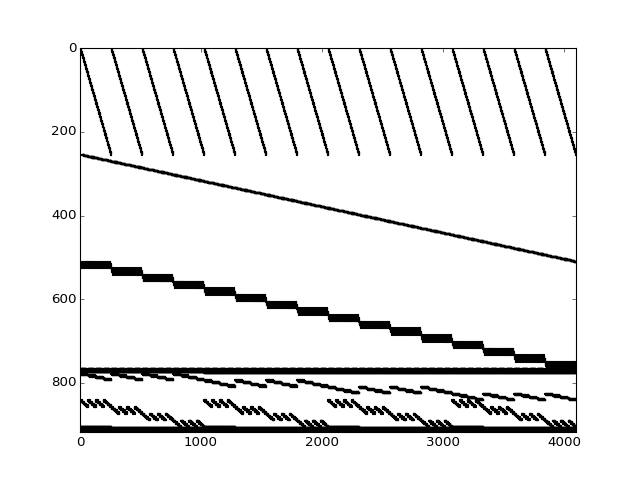

In [7]:
# THIS IS THE GLOBAL ANTECEDENT
g_antecedent = 0 # 4*(4**(2*3)) + 0
g_hg_rows, g_hg, g_hg_cols = hyper_graph(target_A_format_cache, g_antecedent, remove=hg_remove(g_antecedent))
plot_hypergraph(g_hg)

## Iterate Over Found Transversal Indices

In [6]:
def ifi(fts):
    for i in range(fts.shape[1]):
        yield fts[:, i].indices

## Weighted Filtering

In [51]:
def filter_against_target(b, antecedent, hg_rows):
    
    antecedent_value = b[antecedent] # The lhs of the inequality
    marginals_hg_space = b[hg_rows] # The marginals in the space of the hypergraph (values on nodes)
    
    def target_filter(wt):
        """
        wt: The working transversal to consider filtering out
        """
        consequent_values = marginals_hg_space[wt.indices] # The values of the particular consequents
        target = np.sum(consequent_values, axis=0) - antecedent_value # This value *should* be positive if no hardy paradox
        print(target)
        return target >= 0

    return target_filter

## Actually Compute Transversals

In [66]:
# Studying strat objects
example_strat = TransversalStrat(
    search_type='depth',
    find_up_to=20,
    node_brancher={
        'name': 'greedy',
        'max': 4,
#         'ignore' : ignore,
#         'shuffle' : True,
    }
)

example_strat

In [68]:
# Do the transversal

def do_transversal(fts, batch_size, num_batches):
    starting_size = 0 if fts is None else fts.shape[1]
    ending_size = starting_size + batch_size * num_batches
    i = starting_size
    while i < ending_size:
#         print('i is currently:', i)
        batch_strat = TransversalStrat(
            search_type='depth',
#             breadth_cap=5,
#             filter_out=filter_against_target(fritz_dist, g_antecedent, g_hg_rows),
            find_up_to= i + batch_size,
            node_brancher={
#                 'name': 'greedy',
#                 'max': 10,
#                 'ignore' : ignore,
                'shuffle' : True,
            }
        )
        fts = find_transversals(g_hg, strat=batch_strat, log_wt=False, log_ft=False, fts=fts)
        if fts is None:
            break
        i = fts.shape[1]
    return fts

fts = do_transversal(None, 1, 1)

# minimalized_fts = HGT.make_minimal(hg, fts)
# fts = minimalized_fts
fts

<917x1 sparse matrix of type '<class 'numpy.int16'>'
	with 29 stored elements in Compressed Sparse Column format>

## Testing Against Multiple Antecedents

In [11]:
target_dist = fritz(rvc)
target_b = get_b(target_dist, preinjectable_sets, orbit_contractor) # The values corresponding to the preinjectable marginals
positive_antecdents = np.where(target_b >= 1e-6)[0]

In [12]:
no_trans_ant = [0, 16, 34, 50, 64, 80, 98, 114, 136, 152, 170, 186, 200, 216, 234, 250, 256, 272, 290, 306, 320, 336, 354, 370, 392, 408, 426, 442, 456, 472, 490, 506, 513, 529, 547, 577, 593, 611, 665, 683, 699, 713, 729, 747, 763, 769, 819, 833, 849, 867, 883, 905, 939, 955, 969, 985, 1003, 1019, 1024, 1040, 1058, 1074, 1088, 1104, 1122, 1138, 1160, 1176, 1194, 1210, 1224, 1240, 1258, 1274, 1280, 1296, 1314, 1330, 1344, 1360, 1378, 1394, 1416, 1432, 1450, 1466, 1480, 1496, 1514, 1530, 1537, 1553, 1571, 1587, 1601, 1617, 1673, 1689, 1707, 1723, 1753, 1771, 1787, 1793, 1809, 1827, 1843, 1857, 1873, 1907, 1929, 1945, 1963, 1979, 1993, 2027, 2043, 2052, 2068, 2102, 2116, 2132, 2150, 2166, 2188, 2204, 2222, 2238, 2286, 2302, 2308, 2324, 2342]

In [36]:
remaining_antecedents = np.array([a for a in positive_antecdents if a not in no_trans_ant])

In [38]:
bottom_antecedents = remaining_antecedents[remaining_antecedents >= 4*(4**(2*3))]

In [105]:
from quantum_tools.utilities.job_queuer_async import JobContext
import sys

# antecedents = []
# antecedents = list(range(4))
# antecedents = [16384, 16385, 16386, 16387]
# antecedents = [16384]

def get_aprint(antecedent):
    def _aprint(*args):
        print('{:<5} ::'.format(antecedent), *args)
        sys.stdout.flush()
    return _aprint

def parallel_weighted_transversals(antecedents):
    target_args = [[a] for a in antecedents]
    jc = JobContext(weighted_transversal, target_args)
    jc.evaluate()
    return jc.target_results

def get_removal(antecedent):
#     duplicate_antecedents = hg_remove(antecedent)
    larger_positive_consequents = np.where(target_b >= target_b[antecedent])[0]
#     aprint('Number of duplicate antecdents: {}'.format(len(duplicate_antecedents)))
#     aprint('Number of larger possible consequents: {}'.format(len(larger_positive_consequents)))
#     remove = np.append(duplicate_antecedents, larger_positive_consequents)
    return larger_positive_consequents

def weighted_transversal(antecedent, find_up_to=1):
    
    fts_found = []

    aprint = get_aprint(antecedent)
    aprint('Antecedent: {}'.format(antecedent))
    remove = get_removal(antecedent)
    aprint('Length of Removal: {}'.format(len(remove)))
    hg_rows, hg, hg_cols = sort_to_minimize_branching(*hyper_graph(target_A_format_cache, antecedent, remove=remove))
    if not transversals_exist(hg):
        aprint('No transversals to begin with.')
        return fts_found
    aprint('hg.shape: {}'.format(hg.shape))
    aprint('density(hg): {}'.format(utils.sparse_density(hg)))
    strat = TransversalStrat(
        search_type='depth',
        # breadth_cap=5,
        filter_out=filter_against_target(target_b, antecedent, hg_rows),
        starting_transversal=(target_b[hg_rows] == 0)[:, np.newaxis],
        find_up_to=find_up_to,
        node_brancher={
#             'name': 'greedy',
#             'max': 10
            # 'ignore' : ignore,
#             'shuffle' : True,
        }
    )
    fts = find_transversals(hg, strat=strat, log_wt=False, log_ft=False)
    aprint('repr(fts): {}'.format(repr(fts)))
    if fts is not None:
        fts_found.append({
            'antecedent':antecedent,
            'fts':fts,
            'hg_rows':hg_rows,
            'hg':hg,
            'hg_cols':hg_cols,
            'remove':remove,
        })
    return fts_found

In [71]:
bottom_antecedents[1]

16385

In [109]:
weighted_transversal(16385, 1)

16385 :: Antecedent: 16385
16385 :: Length of Removal: 296
16385 :: hg.shape: (4990, 262144)
16385 :: density(hg): 0.0013652304609218437
-0.015625
-1.73472347598e-18
0.015625
0.015625
0.015625
0.001953125
0.00033510327198
0.001953125
0.011383646728
-1.73472347598e-18
0.015625
0.015625
0.015625
0.00033510327198
0.001953125
0.011383646728
0.001953125
-1.73472347598e-18
0.015625
0.015625
0.015625
0.011383646728
0.001953125
0.011383646728
0.001953125
-1.73472347598e-18
0.015625
0.015625
0.00033510327198
0.001953125
0.011383646728
0.001953125
-0.00424135327198
0.011383646728
0.011383646728
0.011383646728
0.011383646728
-0.00228822827198
0.013336771728
0.013336771728
0.013336771728
-0.001953125
0.013671875
0.013671875
0.013671875
0.00943052172802
1.38777878078e-17
0.00943052172802
1.38777878078e-17
-0.00033510327198
0.015289896728
0.015289896728
0.015289896728
0.00161802172802
0.011048543456
0.011048543456
0.00161802172802
0.00909541845604
-0.00033510327198
0.015289896728
0.015289896728
0.01

[]

In [100]:
hg_16385

<4990x262144 sparse matrix of type '<class 'numpy.int16'>'
	with 1785856 stored elements in Compressed Sparse Column format>

<IPython.core.display.Javascript object>


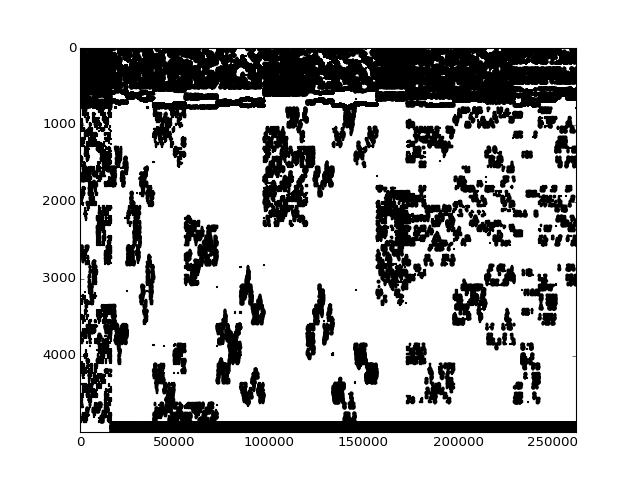

In [102]:
plot_hypergraph(sort_to_minimize_branching(hg_rows_16385, hg_16385, hg_cols_16385)[1])

In [72]:
hg_rows_16385, hg_16385, hg_cols_16385 = hyper_graph(target_A_format_cache, 16385, remove=get_removal(16385))

In [67]:
# fts_16384 = weighted_transversal(16384, 1)[0]
hg_rows_16384, hg_16384, hg_cols_16384 = hyper_graph(target_A_format_cache, 16384, remove=get_removal(16384))

<IPython.core.display.Javascript object>


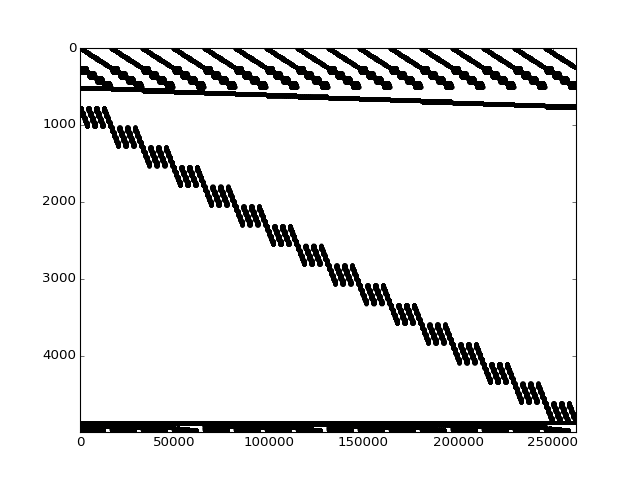

In [73]:
plot_hypergraph(hg_16385)

In [106]:
fts_563 = weighted_transversal(563, 1)[0]

563   :: Antecedent: 563
563   :: Length of Removal: 768
563   :: hg.shape: (756, 4096)
563   :: density(hg): 0.00390625
-0.011383646728
-0.00943052172802
-0.00909541845604
-0.00714229345604
-0.00518916845604
-0.00323604345604
-0.00290094018406
-0.00256583691208
563   :: repr(fts): <756x1 sparse matrix of type '<class 'numpy.int16'>'
	with 727 stored elements in Compressed Sparse Column format>


In [23]:
fts_649 = weighted_transversal(649, 1)[0]

649   :: Antecedent: 649
649   :: Number of duplicate antecdents: 4
649   :: Number of larger possible consequents: 768
649   :: hg.shape: (756, 4096)
649   :: density(hg): 0.00390625
649   :: repr(fts): <756x1 sparse matrix of type '<class 'numpy.int16'>'
	with 727 stored elements in Compressed Sparse Column format>


In [50]:
x = fts_16384
# minimalize_fts_object(x)
# output_to_ineq(fts_649)
print(target_b[x['hg_rows']][x['fts'].indices])
print(np.sum(target_b[x['hg_rows']][x['fts'].indices]))
print(target_b[x['antecedent']])

[ 0.       0.       0.      ...,  0.00195  0.00195  0.01138]
0.020201456544
0.015625


In [26]:
def minimalize_fts_object(fts_object, strat=None, force=False):
    ant     = fts_object['antecedent']
    hg_rows = fts_object['hg_rows']
    hg      = fts_object['hg']
    fts     = fts_object['fts']
    if force or 'minimal_fts' not in fts_object:
        print("Minimalizing...")
        minimal_fts = HGT.make_minimal(hg, fts, strat)
        fts_object['minimal_fts'] = minimal_fts
        print("Done Minimalizing.")

def output_to_ineq(fts_object):
    minimalize_fts_object(fts_object)
    ant     = fts_object['antecedent']
    hg_rows = fts_object['hg_rows']
    hg      = fts_object['hg']
    fts     = fts_object['fts']
    transversal_indices = list(ifi(fts_object['minimal_fts']))
    return Latex(*[transversal_inequality(ant, fts_indices, hg_rows, b_string) for fts_indices in transversal_indices])

def algebraic_equivalence(fts):
    cms = [dict(get_coeff_map(b_string, i)) for i in ifi(fts)]
    return dict_dedup(cms)

def dict_dedup(cms):
    ucms = []
    ucms_i = []
    for cm_i, cm in enumerate(cms):
        is_dup = False
        for ucm_i, ucm in enumerate(ucms):
            if cm == ucm:
                is_dup = True
                break
        if is_dup:
            ucms_i.append(ucm_i)
        else:
            ucms_i.append(len(ucms))
            ucms.append(cm)
    return ucms, ucms_i

<IPython.core.display.Javascript object>


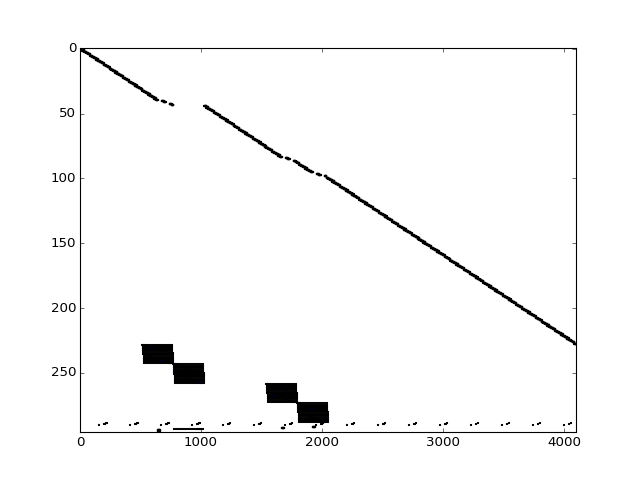

In [218]:
plot_hypergraph(fts_found[0]['hg'][fts_found[0]['minimal_fts'].indices, :])

<IPython.core.display.Javascript object>


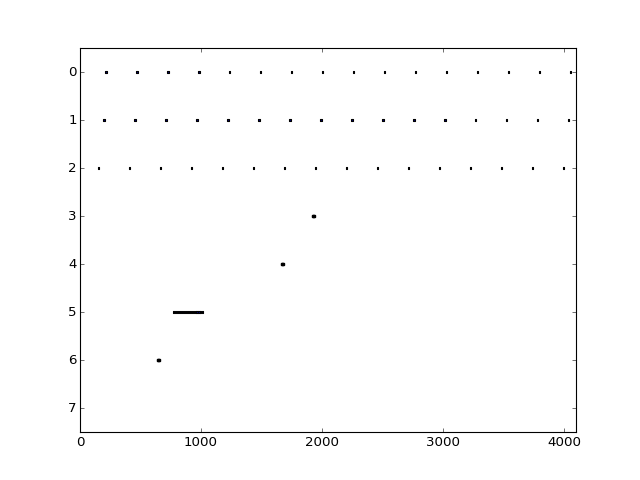

In [212]:
plot_hypergraph(fts_found[0]['hg'][a, :])

<IPython.core.display.Javascript object>


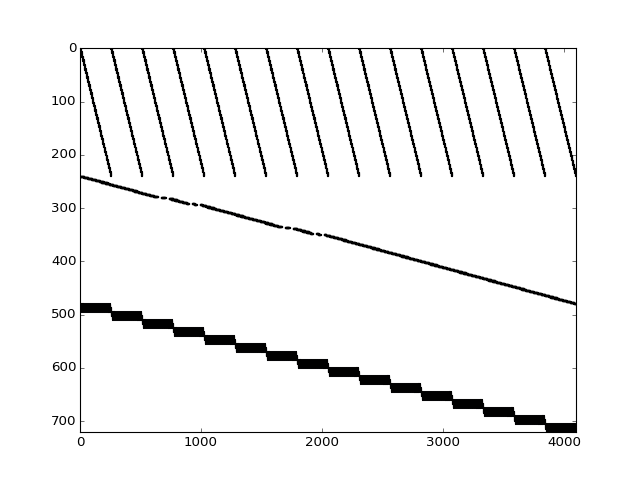

In [213]:
plot_hypergraph(fts_found[0]['hg'][b, :])

In [208]:
x

<756x1 sparse matrix of type '<class 'numpy.int16'>'
	with 304 stored elements in Compressed Sparse Column format>

In [217]:
minimalize_fts_object(fts_found[0], force=True)

Minimalizing...
Done Minimalizing.


In [169]:
fts_found[0]['minimal_fts']

<756x9 sparse matrix of type '<class 'numpy.int16'>'
	with 2489 stored elements in Compressed Sparse Column format>

In [152]:
HGT.is_minimal(fts_found[0]['hg'], )

True

In [164]:
transversal_overlap(fts_found[0]['minimal_fts'])

matrix([[271, 186, 270, 173, 185, 172, 185, 268, 171],
        [186, 283, 185, 270, 268, 269, 282, 197, 268],
        [270, 185, 271, 174, 186, 173, 184, 269, 172],
        [173, 270, 174, 271, 269, 270, 269, 186, 269],
        [185, 268, 186, 269, 284, 270, 267, 196, 269],
        [172, 269, 173, 270, 270, 271, 268, 185, 270],
        [185, 282, 184, 269, 267, 268, 284, 198, 269],
        [268, 197, 269, 186, 196, 185, 198, 283, 186],
        [171, 268, 172, 269, 269, 270, 269, 186, 271]], dtype=int16)

In [87]:
cernikov_filter(_70[0]['minimal_fts'])

<756x9 sparse matrix of type '<class 'numpy.int16'>'
	with 2489 stored elements in Compressed Sparse Column format>

In [137]:
dict_dedup([{'a':1}, {'b':2}, {}]*3)

([{'a': 1}, {'b': 2}, {}], [0, 1, 2, 0, 1, 2, 0, 1, 2])

In [142]:
for indices in ifi(_70[0]['minimal_fts']):
    print(len(indices))

271
283
271
271
284
271
284
283
271


In [141]:
algebraic_equivalence(_70[0]['minimal_fts'])[1]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [119]:
maps[0] == maps[7]

False

In [51]:
def temp_dir(name):
    return os.path.join(NOTEBOOK_FILES_DIR, 'temp', name)

In [50]:
def temp_save(name, obj):
    np.savetxt(temp_dir(name)), np.asarray(obj), fmt='%i', delimiter=',')

In [47]:
temp_save('564_hg_rows.csv', fts_object['hg_rows'] + 1)
temp_save('564_hg_cols.csv', fts_object['hg_cols'] + 1)

In [45]:
temp_save('564_removal.csv', fts_object['remove'] + 1)

In [49]:
temp_save('564_transversal.csv', fts_object['minimal_fts'].indices + 1)

In [53]:
np.savetxt(temp_dir('preinjectable_sets.csv'), b_string, fmt='%s')

In [30]:
print(target_dist)

=== ProbDist ===
RandomVariableCollection
3 Random Variables:
Outcomes: 64 = 4^3
A -> [0, 1, 2, 3]
B -> [0, 1, 2, 3]
C -> [0, 1, 2, 3]
16 Achievable outcomes.
{outcome} -> {probability}
[0, 0, 0] -> 0.1066941738241591
[0, 1, 0] -> 0.018305826175840763
[0, 2, 2] -> 0.1066941738241591
[0, 3, 2] -> 0.018305826175840756
[1, 0, 0] -> 0.018305826175840756
[1, 1, 0] -> 0.1066941738241591
[1, 2, 2] -> 0.01830582617584075
[1, 3, 2] -> 0.1066941738241591
[2, 0, 1] -> 0.1066941738241591
[2, 1, 1] -> 0.01830582617584075
[2, 2, 3] -> 0.018305826175840756
[2, 3, 3] -> 0.1066941738241591
[3, 0, 1] -> 0.01830582617584075
[3, 1, 1] -> 0.10669417382415913
[3, 2, 3] -> 0.1066941738241591
[3, 3, 3] -> 0.01830582617584075


In [31]:
Latex(get_expression_latex(b_string, fts_object['hg_rows'][fts_object['positive_con']], ', '))

## Visualizing Particular Transversals

/usr/local/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


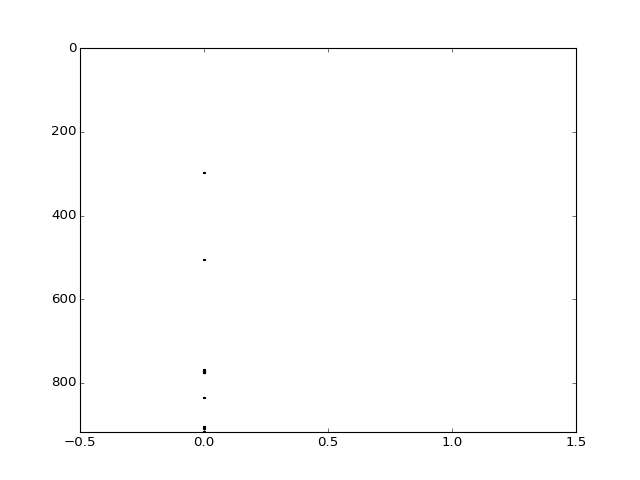

In [188]:
plot_transversals(fts)

/usr/local/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


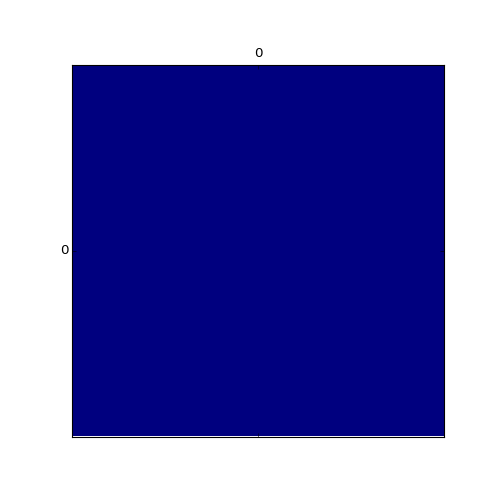

In [189]:
visualize_overlap(fts)

### Storing computed transversals (Evaluated Once)

In [55]:
# utils.save_sparse('ABC_444_444_A_fts_ant_30_depth_5000.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_30_depth_5000.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<920x5000 sparse matrix of type '<class 'numpy.int32'>'
	with 151351 stored elements in Compressed Sparse Column format>

In [114]:
# utils.save_sparse('ABC_444_444_A_fts_ant_0_depth_16500.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_0_depth_16500.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<920x16500 sparse matrix of type '<class 'numpy.int32'>'
	with 490799 stored elements in Compressed Sparse Column format>

In [65]:
# utils.save_sparse('ABC_444_444_A_fts_ant_0_depth_6150_no_orbits.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_0_depth_6150_no_orbits.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<917x6150 sparse matrix of type '<class 'numpy.int32'>'
	with 96148 stored elements in Compressed Sparse Column format>

In [96]:
# utils.save_sparse('ABC_444_444_A_fts_ant_0_depth_500_orbits.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_0_depth_500_orbits.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<95x450 sparse matrix of type '<class 'numpy.int32'>'
	with 5404 stored elements in Compressed Sparse Column format>

## Testing against particular distributions

In [9]:
def triangle_test(pd, log):
    targets = pd_to_ineq_target(pd, preinjectable_sets, fts, antecedent, hg_rows, multi=True, orbit_contractor=orbit_contractor)
    if np.any(targets<0):
        print("Found {} Violations".format(log))
    else:
        print("No {} Violations".format(log))
    return pd

In [29]:
triangle_test(uniform_qdistro(rvc, dimensions), 'Quantum')
triangle_test(uniform_discrete(rvc), 'Correlation')
triangle_test(c4_type(rvc), 'C4-type')
triangle_test(perfect_correlation(rvc), 'Perfect Correlation')
triangle_test(fritz(rvc), 'Fritz')
triangle_test(spekkens(rvc), 'Spekkens')

NameError: name 'fts' is not defined

## Optimizing against a Particular Inequality

In [21]:
def hom_optimize(transversal_index):
    try:
        ht = fts[:, transversal_index].indices
        hom = HardyOrbitMinimizer(ht, log=False)
        hom.minimize()
        if hom.best_objective_result < 0:
            hom.save_results_to_file(OUTPUT_DIR + "HOM_winner_{0}.txt".format(transversal_index))
        return hom.best_objective_result
    except Exception as e:
        print(e)
        return 0

index_choice = np.random.choice(list(range(fts.shape[1])), size=10)
print([[i] for i in index_choice])
jc = JobContext(hom_optimize, [[i] for i in index_choice])
jc.evaluate()
print(jc.target_results)

[[98], [97], [39], [59], [21], [45], [51], [31], [59], [88]]
JobContext requested 15 cores.
JobContext using 10 cores.
Sub-Job Finished: 10%
Sub-Job Finished: 20%
Sub-Job Finished: 30%
Sub-Job Finished: 40%
Sub-Job Finished: 50%
Sub-Job Finished: 60%
Sub-Job Finished: 70%
Sub-Job Finished: 80%
Sub-Job Finished: 90%
Sub-Job Finished: 100%
[0.0086770806600836858, 0.013366609248564174, 0.0057875823119305902, 0.0093635733369834204, 0.0053649816860059044, 0.0035641655186516765, 0.0094170434131358796, 0.0094170434131358796, 0.0015512539114570822, 0.0017380199580880023]


In [8]:
# TESTING JOBCONTEXT
import time

def f(a,b,c):
    for i in range(100000000):
        i*i
#     time.sleep(6)
    return a - b * c

def test():
    jc = JobContext(f, [[1,2,3], [2,3,4], [3,4,5], [3, 4, 5], [3, 4, 11]]*6)
    jc.evaluate()
    for result in jc.target_results:
        print(result)
test()

JobContext requested 15 cores.
JobContext using 15 cores.
Caught KeyboardInterrupt, terminating workers.


In [9]:
# dimensions = 2 # Needed for computational feasibility
hom_transversal = fts[:, min(30, fts.shape[1] - 1)].indices # pick a particular transversal to optimize against
# print(hom_transversal)
hom = HardyOrbitMinimizer(hom_transversal, log=True)
hom.minimize()
# PROFILE_MIXIN(hom.minimize)
# hom.save_results_to_file(OUTPUT_DIR + "HOM_temp.txt")

NameError: name 'fts' is not defined

In [94]:
conv_transversal = fts[:, -1].indices
con_minimizer = ConvexityMinimizer(conv_transversal, log=True)
con_minimizer.minimize()

'Minimize Step result: 2.576894728510665'
'New Best Objective Result: 2.576894728510665'
'Minimize Step result: 2.0706635015745594'
'New Best Objective Result: 2.0706635015745594'
'Minimize Step result: 1.8464379087909524'
'New Best Objective Result: 1.8464379087909524'
'Minimize Step result: 1.6516935745066168'
'New Best Objective Result: 1.6516935745066168'
'Minimize Step result: 1.5568123741557636'
'New Best Objective Result: 1.5568123741557636'
'Minimize Step result: 1.454567203205219'
'New Best Objective Result: 1.454567203205219'
'Minimize Step result: 1.3529656592139683'
'New Best Objective Result: 1.3529656592139683'
'Minimize Step result: 1.0383235384011689'
'New Best Objective Result: 1.0383235384011689'
'Minimize Step result: 0.8885569362367169'
'New Best Objective Result: 0.8885569362367169'
'Minimize Step result: 0.8630828196011016'
'New Best Objective Result: 0.8630828196011016'
'Minimize Step result: 0.8321599041325842'
'New Best Objective Result: 0.8321599041325842'
'Mi

In [86]:
print(con_minimizer.best_objective_result)
print(con_minimizer.best_context)

0.000700675778398
=== ProbDist ===
RandomVariableCollection
3 Random Variables:
Outcomes: 64 = 4^3
A -> [0, 1, 2, 3]
B -> [0, 1, 2, 3]
C -> [0, 1, 2, 3]
64 Achievable outcomes.
{outcome} -> {probability}
[0, 0, 0] -> 4.2127877521906056e-05
[0, 0, 1] -> 2.7075630677110535e-07
[0, 0, 2] -> 3.832318635032471e-07
[0, 0, 3] -> 3.7174694457427755e-07
[0, 1, 0] -> 0.19780322316066407
[0, 1, 1] -> 0.0006998994700550562
[0, 1, 2] -> 9.83560942199544e-10
[0, 1, 3] -> 7.1248451561328265e-06
[0, 2, 0] -> 7.121367540090533e-05
[0, 2, 1] -> 8.442785976501646e-09
[0, 2, 2] -> 2.093904140030005e-08
[0, 2, 3] -> 4.576508231665934e-12
[0, 3, 0] -> 0.19780262729311895
[0, 3, 1] -> 0.004776826064602654
[0, 3, 2] -> 2.6591340009510706e-13
[0, 3, 3] -> 2.0126268145061402e-05
[1, 0, 0] -> 2.2864350227506704e-09
[1, 0, 1] -> 2.6508270096819307e-06
[1, 0, 2] -> 1.3671178448164577e-06
[1, 0, 3] -> 2.4043019529283347e-10
[1, 1, 0] -> 1.0007616385152933e-06
[1, 1, 1] -> 7.185718212574238e-06
[1, 1, 2] -> 5.877124

In [30]:
import numpy as np
from quantum_tools.optimizers.minimizer import Minimizer
from quantum_tools.utilities import utils
from quantum_tools.config import *
from quantum_tools.contexts.measurement import Measurement
from quantum_tools.contexts.state import State
from quantum_tools.statistics.variable import RandomVariableCollection
from quantum_tools.inflation import marginal_equality
from quantum_tools.examples import symbolic_contexts
from quantum_tools.contexts.quantum_context import QuantumContext, QuantumProbDist, QuantumProbDistOptimized

class HardyOrbitMinimizer(Minimizer):

    def __init__(self, transversal_indices, log=False):
        Minimizer.__init__(self, [32,32,32,16,16,16])
        self.local_log = log
        self.permutation = triangle_permutation
        self.random_variables = rvc
        self.tolerance = 1e-3
        self.max_evals = 1
        self.step_size = 100
        self.transversal_indices = transversal_indices
#         self.preinjectable_sets = 
#         self.orbit_contractor = row_sum
#         self.antecedent = antecedent
#         self.transversal_indicies = transversal_indicies # pick a particular transversal to optimize against
#         self.hg_rows = hg_rows

    def initial_guess(self):
        initial_guess = np.random.normal(scale=10.0, size=self.mem_size)
        return initial_guess

    def get_context(self, param):
        pA, pB, pC, prhoAB, prhoBC, prhoAC = self.mem_slots
        A = Measurement.Strats.Param.pvms(param[pA])
        B = Measurement.Strats.Param.pvms(param[pB])
        C = Measurement.Strats.Param.pvms(param[pC])
        rhoAB = State.Strats.Param.dm(param[prhoAB])
        rhoBC = State.Strats.Param.dm(param[prhoBC])
        rhoAC = State.Strats.Param.dm(param[prhoAC])

        qc = QuantumContext(
            random_variables=self.random_variables,
            measurements=(A,B,C),
            states=(rhoAB,rhoBC,rhoAC),
            permutation=self.permutation,
        )
        return qc

    def objective(self, param):
        qc = self.get_context(param)
        pd = QuantumProbDistOptimized(qc)

        target = pd_to_ineq_target(pd, self.transversal_indices)
        self.log("Calculated objective:", target)
        return target

In [27]:
import numpy as np
from quantum_tools.optimizers.minimizer import Minimizer
from quantum_tools.utilities import utils
from quantum_tools.config import *

class ConvexityMinimizer(Minimizer):

    def __init__(self, transversal_indices, log=False):
        Minimizer.__init__(self, [len(rvc.outcome_space)])
        self.local_log = log
        self.random_variables = rvc
        self.transversal_indices = transversal_indices
        self.tolerance = 1e-3
        self.max_evals = 2
        self.step_size = 100

    def initial_guess(self):
        initial_guess = np.random.normal(scale=10.0, size=self.mem_size)
        return initial_guess

    def get_context(self, param):
        pAll = self.mem_slots
        param_shaped = param[pAll].reshape(self.random_variables.outcome_space.get_input_base())
        param_shaped = np.cos(param_shaped, param_shaped)**2
        param_shaped /= np.sum(param_shaped)
        support = param_shaped
        
        return ProbDist(self.random_variables, support)

    def objective(self, param):
        pd = self.get_context(param)

        target = pd_to_ineq_target(pd, self.transversal_indices)
#         if partial_log(.01):
#             self.log("Calculated objective:", target)
        return target